In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import numpy as np
import os
import argparse

from matplotlib import pyplot as plt

from PIL import Image
from torch.utils.data import Dataset

import segmentation_models_pytorch as sm

# loss_type = "mse"
loss_type = "bce"

In [2]:
transform_train = transforms.Compose([
#     transforms.Resize((256, 256)),
    transforms.RandomAffine(15, translate=[0.05,0.05], scale=[0.9,1.1]), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize( [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, data_dirs, transform):
        self.transform = transform
        self.main_dir = main_dir
        self.total_imgs = data_dirs

    def __len__(self): return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        if loss_type == "mse":
            if "norm" in img_loc: 
                return tensor_image[:1,:,:], torch.Tensor([0]).float()
            if "abn" in img_loc: 
                return tensor_image[:1,:,:], torch.Tensor([1]).float()
        elif loss_type == "bce":
            if "norm" in img_loc: 
                return tensor_image[:1,:,:], torch.Tensor([0]).long()
            if "abn" in img_loc: 
                return tensor_image[:1,:,:], torch.Tensor([1]).long()

from sklearn.model_selection import train_test_split
main_dir ="./0822data/256png/"
train_dirs, test_dirs = train_test_split(os.listdir(main_dir), test_size = 0.2)

train_dataset = CustomDataSet(main_dir, train_dirs, transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=16, shuffle=True, 
                                           num_workers=0, pin_memory=True, drop_last=True)
test_dataset = CustomDataSet(main_dir, test_dirs, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset , batch_size=16, shuffle=False, 
                                          num_workers=0, pin_memory=True, drop_last=False)

In [3]:
import torchvision.models as models
model = models.resnet18(weights=None)
if loss_type == "mse":
    model.fc = nn.Linear(512, 1)
elif loss_type == "bce":
    model.fc = nn.Linear(512, 2)
device = 'cuda'
model.to(device)
print("model is OK")

model is OK


In [4]:
if loss_type == "mse":
    criterion = nn.MSELoss()
elif loss_type == "bce":
    criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
overall_loss = list()
overall_acc = list()

for iteration in range(50):
    
    model.train()
    print(iteration)
    train_loss, train_correct, train_count = 0, 0, 0
    for train_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.repeat(1,3,1,1)
        if loss_type == "mse":
            inputs, targets = inputs.to(device), targets.to(device)
        elif loss_type == "bce":
            inputs, targets = inputs.to(device), targets[:,0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if loss_type == "mse":
            train_correct += torch.eq((outputs[:,:1]>0.5)*1, targets).sum().item()
        elif loss_type == "bce":
            pred = F.softmax(outputs, dim=1).argmax(dim=1)
            train_correct += torch.eq(pred, targets).sum().item()  # convert to numpy
        train_count += len(targets)
    
    test_loss, test_correct, test_count = 0, 0, 0
    model.eval()
    for test_idx, (inputs, targets) in enumerate(test_loader):     
        inputs = inputs.repeat(1,3,1,1)
        if loss_type == "mse":
            inputs, targets = inputs.to(device), targets.to(device)
        elif loss_type == "bce":
            inputs, targets = inputs.to(device), targets[:,0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        
        if loss_type == "mse":
            test_correct += torch.eq((outputs[:,:1]>0.5)*1, targets).sum().item()
        elif loss_type == "bce":
            pred = F.softmax(outputs, dim=1).argmax(dim=1)
            test_correct += torch.eq(pred, targets).sum().item()  # convert to numpy
        test_count += len(targets)
        
    overall_loss.append([train_loss/(train_idx+1), test_loss/(test_idx+1)])
    overall_acc.append([train_correct/train_count, test_correct/test_count])
    
overall_loss = np.array(overall_loss)
overall_acc = np.array(overall_acc)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


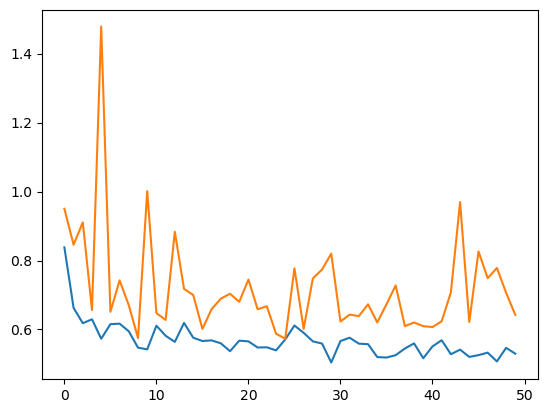

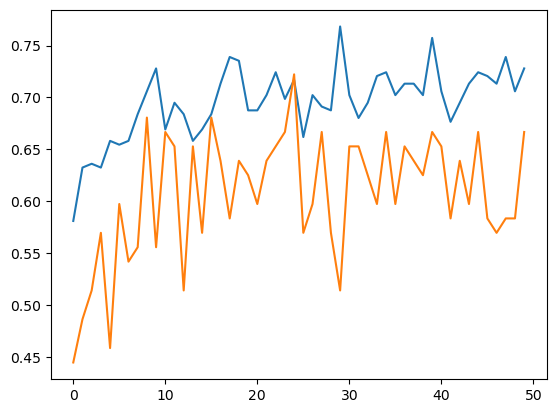

In [5]:
plt.plot(overall_loss[:,0], label="train loss")
plt.plot(overall_loss[:,1], label="test loss")
plt.pause(0.1)
plt.plot(overall_acc[:,0], label="train acc")
plt.plot(overall_acc[:,1], label="test acc")
plt.pause(0.1)

In [ ]:
import torch

print(torch.__version__)


In [ ]:
pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU
    
    print(f"CUDA is available with {num_gpus} GPU(s).")
    print(f"Current GPU: {current_gpu}")
else:
    print("CUDA is not available. PyTorch will run on CPU.")


In [ ]:
import torch
print(torch.cuda.is_available())


In [ ]:
!nvcc --version


In [ ]:
nvcc --version



In [ ]:
pip install --upgrade pip setuptools
